# Parameter Space - 1D Example

In [1]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import warnings
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.toy import generate_dependence_data
from data.distribution import DataParams
from features.utils import dict_product


# Kernel Dependency measure
from sklearn.gaussian_process.kernels import RBF
from pysim.kernel.hsic import HSIC
from pysim.kernel.utils import estimate_sigma, get_sigma_grid#GammaParam, SigmaParam

# RBIG IT measures
from models.dependence import HSICModel

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from tqdm import tqdm
from experiments.utils import dict_product, run_parallel_step

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-paper'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Useful Functions

I've broken down the components so that it's easier to pass appropriate parameters. The main functions as as follows:

* Standardize Data
    * yes or no
* Get Sigma
    * Handles the ways to estimate the parameter
    * per dimension
    * per dataset (x and/or y)
    * estimator (median, mean, silverman, scott, etc)
* Get HSIC scorer
    * Handles the HSIC method (hsic, ka, cka)

In [2]:
from typing import Optional, Tuple

def standardize_data(
    X: np.ndarray, 
    Y: np.ndarray, 
    standardize: bool=False
) -> Tuple[np.ndarray, np.ndarray]:
    X = StandardScaler().fit_transform(X)
    Y = StandardScaler().fit_transform(Y)
    return X, Y

def get_sigma(
    X: np.ndarray, 
    Y: np.ndarray, 
    method: str='silverman', 
    percent: Optional[float]=None,
    per_dimension: bool=False, 
    separate_scales: bool=False
) -> Tuple[np.ndarray, np.ndarray]:
    # sigma parameters
    subsample = None
    random_state = 123
    
    sigma_X = estimate_sigma(
        X, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )
    
    sigma_Y = estimate_sigma(
        Y, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )
    
    if separate_scales:
        sigma_X = np.mean([sigma_X, sigma_Y])
        sigma_Y = np.mean([sigma_X, sigma_Y])
    return sigma_X, sigma_Y

def get_hsic(
    X: np.ndarray, 
    Y: np.ndarray, 
    scorer: str, 
    sigma_X: Optional[float]=None, 
    sigma_Y: Optional[float]=None
) -> float:
    
    # init hsic model class
    
    hsic_model = HSICModel()
    # hsic model params
    if sigma_X is not None:
        
        hsic_model.kernel_X = RBF(sigma_X)
        hsic_model.kernel_Y = RBF(sigma_Y)

    # get hsic score
    hsic_val = hsic_model.get_score(X, Y, scorer)
    
    return hsic_val

def plot_toy_data(X, Y, subsample: Optional[int]=None):
    
    # plot
    fig, ax = plt.subplots()

    ax.scatter(X[:subsample,:], Y[:subsample,:])
    return fig, ax


## Datasets

For this experiment, we will be looking at 4 simple 1D datasets:

* Line
* Sine
* Circle
* Random

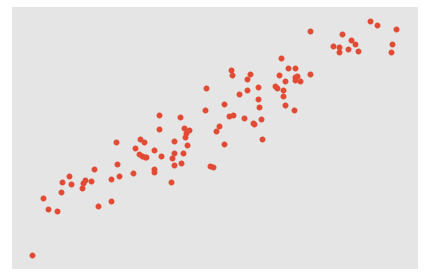

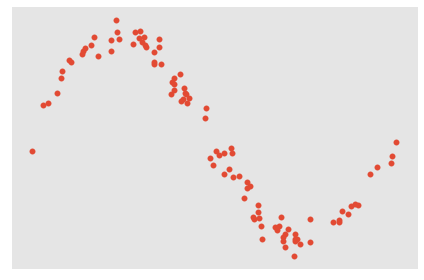

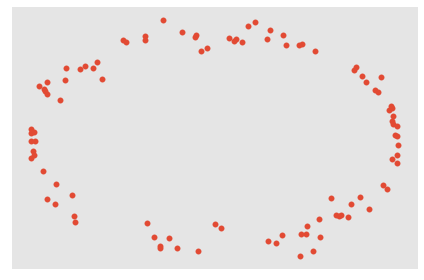

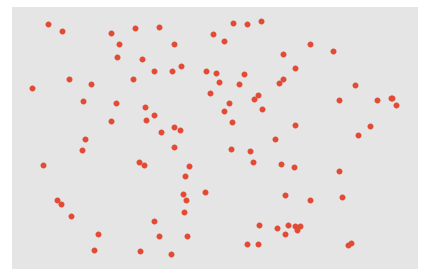

In [236]:
datasets = ['line', 'sine', 'circle', 'random']
num_points = 1_000
seed = 123
noise = 0.1

for idataset in datasets:
    # get dataset
    X, Y = generate_dependence_data(
        dataset=idataset,
        num_points=num_points,
        seed=seed,
        noise_x=noise,
        noise_y=noise
    )
    
    fig, ax = plot_toy_data(X, Y, 100)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
#     fig.savefig(FIG_PATH + f"demo_{idataset}.png")
    plt.show()

## Research Questions

* Which Algorithm?
* Which Parameter Estimator?
* Standardize or Not?

## Part I - The Sigma Space

### Experiment

For this first part, we want to look a the entire $\sigma$ space for the RBF kernel. We will vary the $\sigma$ parameter and use 20 grid poinnts for both $X$ and $Y$. Since we're dealing with 1D data, we will not have to worry about per dimension estimates.

**Free Parameters**

* Dataset (sine, line, circle, random)
* Scorer (hsic, cka, ka)
* Sigma X,Y (grid space)

We fix all other parameters as they are not necessary for this first step.

In [86]:
sigma_grid, sigma_X

(<function __main__.sigma_grid(sigma_X, factor=4, n_grid_points=20)>,
 0.32917944341805494)

In [209]:
sigma_grid(sigma_X, factor=2)

array([3.29179443e-03, 5.34513923e-03, 8.67931275e-03, 1.40932662e-02,
       2.28843178e-02, 3.71590229e-02, 6.03379570e-02, 9.79753711e-02,
       1.59090129e-01, 2.58326850e-01, 4.19465131e-01, 6.81117722e-01,
       1.10598311e+00, 1.79586965e+00, 2.91609137e+00, 4.73508134e+00,
       7.68871493e+00, 1.24847565e+01, 2.02724571e+01, 3.29179443e+01])

In [210]:
def sigma_grid(sigma_X, factor=2, n_grid_points=20):
    return np.logspace(
        np.log10(sigma_X * 10**(-factor)),
        np.log10(sigma_X * 10**(factor)),
        n_grid_points
    )

In [212]:
# experimental parameters
n_grid_points = 40
# sigma_grid = np.logspace(-3, 3, n_grid_points)

# initialize sigma (use the median)
sigma_X, sigma_Y = get_sigma(X,Y, method='mean')
print(sigma_X, sigma_Y)

# create a grid
sigma_X_grid = sigma_grid(sigma_X, factor=3, n_grid_points=n_grid_points)
sigma_Y_grid = sigma_grid(sigma_Y, factor=3, n_grid_points=n_grid_points)

# create a parameter grid
parameters = {
    "dataset": ['sine', 'line', 'random', 'circle'],
    "scorer": ['hsic', 'ka', 'cka'],
    "sigma_X": np.copy(sigma_X_grid),
    "sigma_Y": np.copy(sigma_Y_grid),
}

# Get a list of all parameters
parameters = list(dict_product(parameters))

# check # of parameters
n_params = len(parameters)
print(f"Number of params: {n_params}")
print(f"First set of params:\n{parameters[0]}")

0.32917944341805494 0.3439255265652333
Number of params: 19200
First set of params:
{'dataset': 'sine', 'scorer': 'hsic', 'sigma_X': 0.00032917944341805485, 'sigma_Y': 0.00034392552656523323}


This made a list of dictionary values with every possible combination of the parameters we listed. Now if we call the first element of this list, we can pass these parameters into our HSIC function to calculate the score. This allows us to do the calculations in parallel instead of looping through every single combination.

Now, we need to make an experimental step function. This function will be the HSIC function that called within the parallel loop. I want it to also return a `pd.DataFrame` with the columns holding the parameters. This will make things easier for us to keep track of things as well as plot our results.

In [213]:
from typing import Dict

def step(params: Dict, X: np.ndarray, Y: np.ndarray)-> pd.DataFrame:
    
    # get dataset
    X, Y = generate_dependence_data(
        dataset=params['dataset'],
        num_points=1_000,
        seed=123,
        noise_x=0.1,
        noise_y=0.1
    )
    
    # calculate the hsic value
    score = get_hsic(X, Y, params['scorer'], params['sigma_X'], params['sigma_Y'])
    
    # create a dataframe with the results and params
    results_df = pd.DataFrame({
        'dataset': [params['dataset']],
        'scorer': [params['scorer']],
        'sigma_X': [params['sigma_X']],
        'sigma_Y': [params['sigma_Y']],
        'score': score,
    },)
    
    return results_df

In [214]:
# test the result
res_test = step(parameters[0], X, Y)

# quick test
res_keys = ['dataset', 'scorer', 'sigma_X', 'sigma_Y', 'score']
assert res_keys == res_test.columns.tolist()

# print out results
res_test.head().to_markdown()

'|    | dataset   | scorer   |     sigma_X |     sigma_Y |       score |\n|---:|:----------|:---------|------------:|------------:|------------:|\n|  0 | sine      | hsic     | 0.000329179 | 0.000343926 | 0.000997738 |'

Now we can loop through and calculate the hsic value for each of the $\sigma$-parameters that we have enlisted. And we will do it in parallel to save time. I'm on a server with 28 cores free so best believe I will be using all of them...

In [215]:
verbose = 1
n_jobs = -1

results = run_parallel_step(
    exp_step=step, 
    parameters=parameters,
    n_jobs=n_jobs,
    verbose=verbose,
    X=X,
    Y=Y
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 7932 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 11932 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 14232 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 16732 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 19145 out of 19200 | elapsed:  2.0min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 19200 out of 19200 | elapsed:  2.0min finished


In [216]:
# test (number of results = n parameters)
assert n_params == len(results)

results_df = pd.concat(results, ignore_index=True)
results_df.head().to_markdown()

'|    | dataset   | scorer   |     sigma_X |     sigma_Y |       score |\n|---:|:----------|:---------|------------:|------------:|------------:|\n|  0 | sine      | hsic     | 0.000329179 | 0.000343926 | 0.000997738 |\n|  1 | sine      | hsic     | 0.000329179 | 0.000490129 | 0.000997927 |\n|  2 | sine      | hsic     | 0.000329179 | 0.000698484 | 0.000998668 |\n|  3 | sine      | hsic     | 0.000329179 | 0.000995412 | 0.000999668 |\n|  4 | sine      | hsic     | 0.000329179 | 0.00141856  | 0.00100054  |'

### Visualization - Heatmap

To visualize the space, I will use a heatmap with the X,Y-axes for the $\sigma$-parameter and a colorbar to display the actual values we obtain. 

**Note**: The HSIC method has an infinite range whereas the CKA and KA methods will have a range between 0 and 1. In my personal experience, I've yet to see HSIC values go past 0.11 so I will use that as an upper bound for the visualization.

#### Plot Function

In [217]:


def plot_gamma_grid(grid_df: pd.DataFrame, scorer: str, dataset: str, ax: Optional=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6.5))
    
    # ===========================================
    # Plot Gridded DataFrame
    # ===========================================
    

    # subset hsic method
    grid_df_ = grid_df[grid_df['scorer'] == scorer].drop('scorer', axis=1)
    
    # subset dataset
    grid_df_ = grid_df_[grid_df_['dataset'] == dataset].drop('dataset', axis=1)
    
    # create a heatmap
    grid_df_ = pd.pivot_table(grid_df_, values='score', index=['sigma_Y'], columns='sigma_X')
#     print(grid_df_)
    # min max
    if scorer == 'hsic':
        vmax = 0.11
    else:
        vmax = 1.0

    # heatmap_data.columns = np.sqrt(1 / 2 * heatmap_data.columns.values)
    # heatmap_data.index = np.sqrt(1 / 2 * heatmap_data.index.values)
    pts = sns.heatmap(
        data=grid_df_,
        xticklabels=grid_df_.columns.values.round(decimals=2),
        yticklabels=grid_df_.index.values.round(decimals=2),
        vmin=0, vmax=vmax, ax=ax
    )
    

    return fig, ax


#### Line Dataset

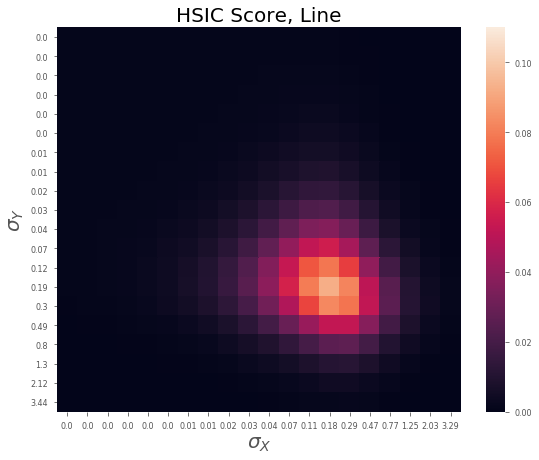

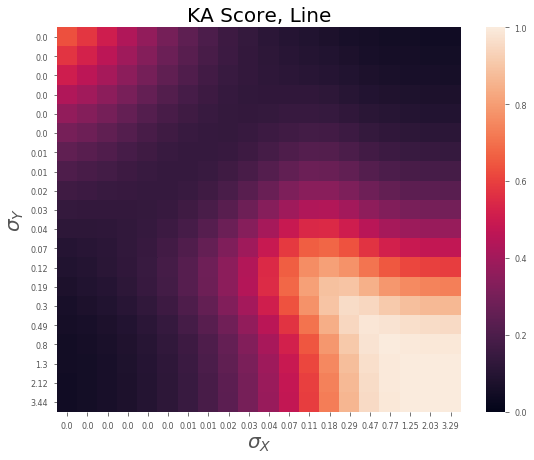

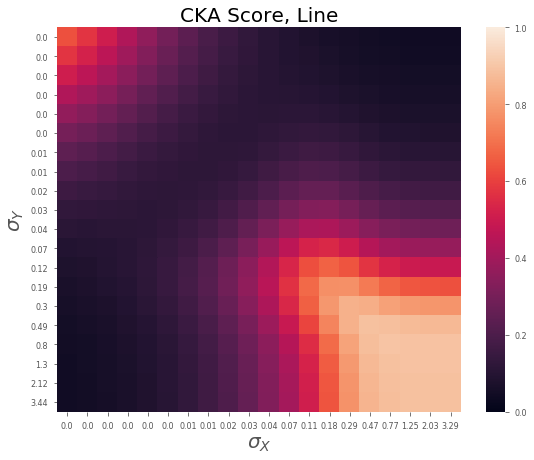

In [70]:
scorers = results_df['scorer'].unique().tolist()
idataset = 'line'

for iscorer in scorers:

    fig, ax = plot_gamma_grid(results_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

We see that the HSIC method is different that the CKA and KA. There is an "absolutely maximum" value that is present whereas the CKA and KA methods seem to have values that where they find maximum dependence. It's also interpretable because they are both at 1.

#### Sine Dataset

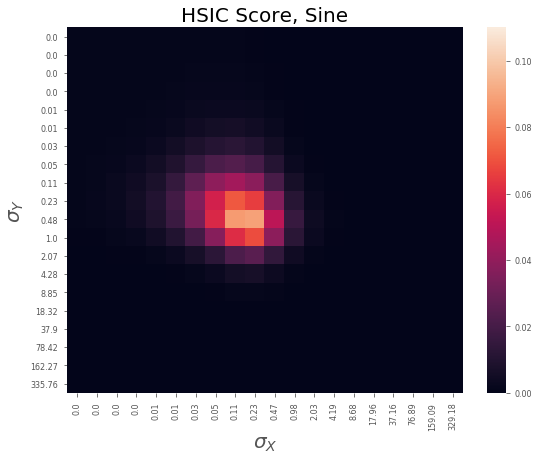

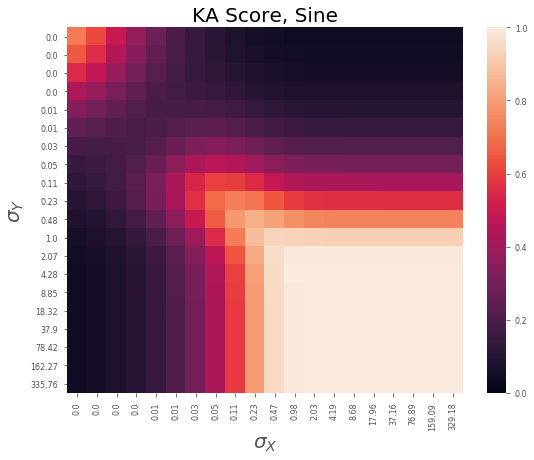

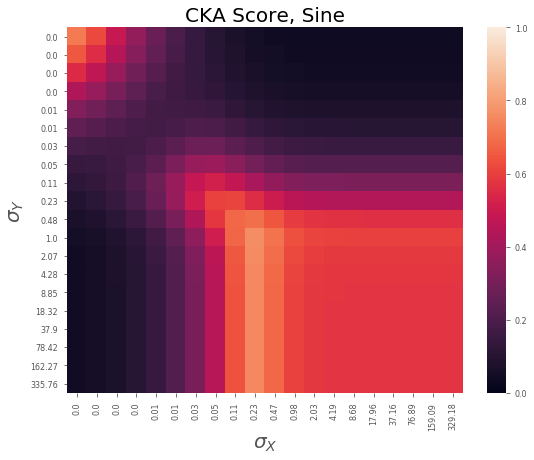

In [89]:
idataset = 'sine'

for iscorer in scorers:

    fig, ax = plot_gamma_grid(results_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

The HSIC and the CKA method both show a decrease in the estimate for dependence for all values. The KA does not and looks very similar to the Line dataset.

#### Circle Dataset

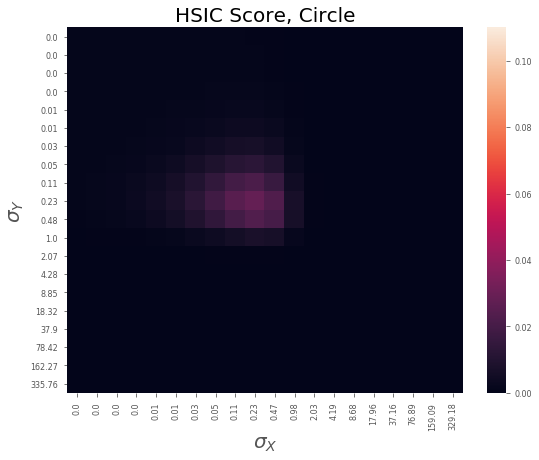

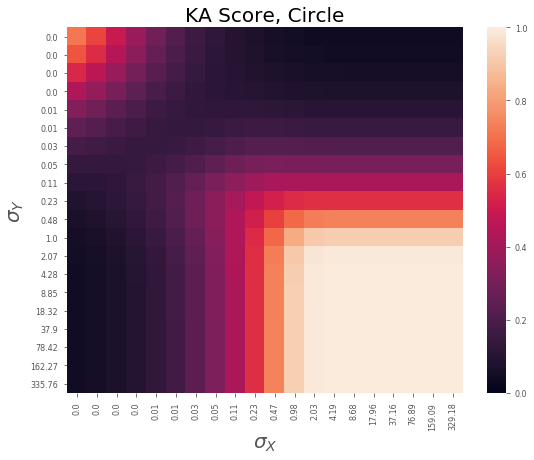

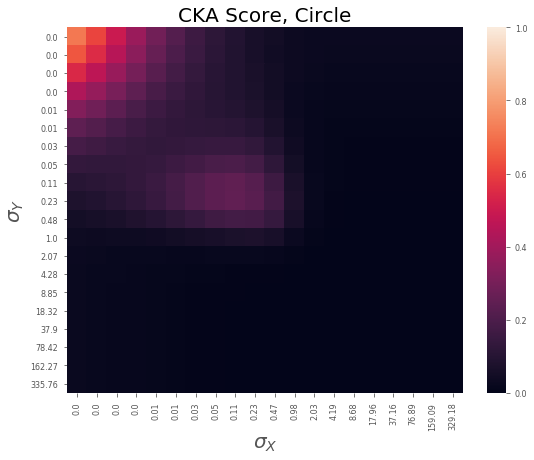

In [90]:
idataset = 'circle'

for iscorer in scorers:

    fig, ax = plot_gamma_grid(results_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

Yet another decrease in the score for the HSIC and the CKA and the KA is still very similar to the line and the sine dataset. The shapes of HSIC and CKA also seem to be more similar relatively speaking.

#### Random Dataset

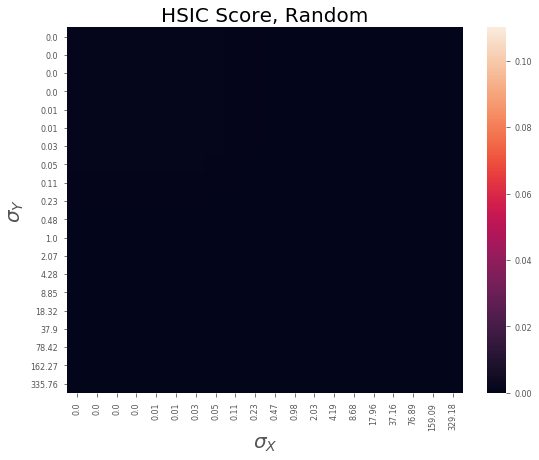

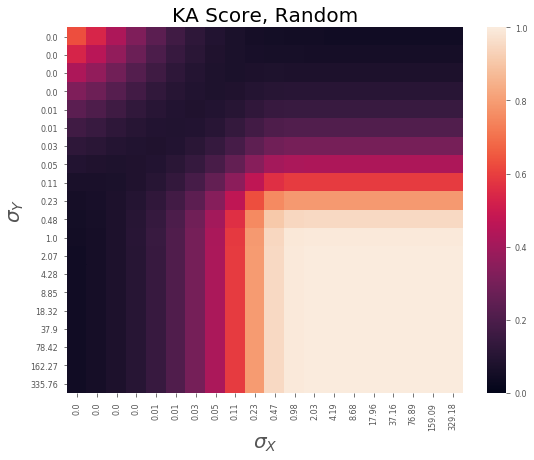

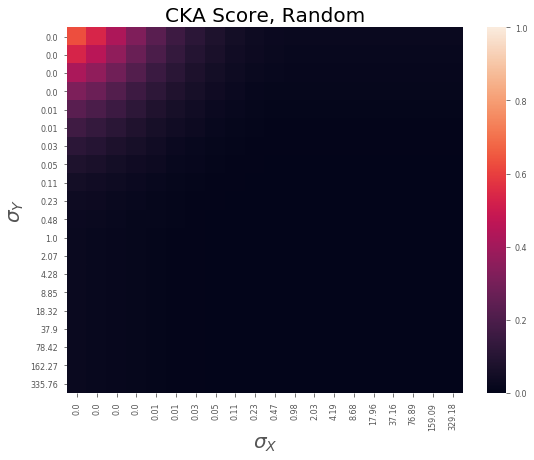

In [91]:
idataset = 'random'

for iscorer in scorers:

    fig, ax = plot_gamma_grid(results_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

We can see that the $\sigma$-space for the random values makes sense for the HSIC and the CKA but not the KA. There should be absolutely no dependence whatsoever.

## Part II - Specific Methods

In the above section, we showed the full parameter space. But what happens if we just look at specific ways to estimate the sigma? For th

**Free Parameters**:

* Dataset (sine, line, circle, random)
* Scorer (hsic, cka, ka)
* Sigma Estimator (mean, median, silverman, scott)

### Experiment

In [9]:
# initialize sigma (use the median)
sigma_X, sigma_Y = get_sigma(X,Y, method='mean')

# create a parameter grid
parameters = {
    "dataset": ['sine', 'line', 'random', 'circle'],
    "scorer": ['hsic', 'ka', 'cka'],
    "estimator": ['mean', 'median', 'mean']
}

# Get a list of all parameters
parameters = list(dict_product(parameters))

# check # of parameters
n_params = len(parameters)
print(f"Number of params: {n_params}")
print(f"First set of params:\n{parameters[0]}")

Number of params: 36
First set of params:
{'dataset': 'sine', 'scorer': 'hsic', 'estimator': 'mean'}


In [20]:
from typing import Dict

def step(params: Dict, X: np.ndarray, Y: np.ndarray)-> pd.DataFrame:
    
    # get dataset
    X, Y = generate_dependence_data(
        dataset=params['dataset'],
        num_points=1_000,
        seed=123,
        noise_x=0.1,
        noise_y=0.1
    )
    # estimate sigma
    sigma_X, sigma_Y = get_sigma(X, Y, method=params['estimator'])
    
    # calculate the hsic value
    score = get_hsic(X, Y, params['scorer'], sigma_X, sigma_Y)
    
    # create a dataframe with the results and params
    results_df = pd.DataFrame({
        'dataset': [params['dataset']],
        'scorer': [params['scorer']],
        'estimator': [params['estimator']],
        'sigma_X': [sigma_X],
        'sigma_Y': [sigma_Y],
        'score': score,
    },)
    
    return results_df

In [21]:
# test the result
res_test = step(parameters[0], X, Y)

# quick test
res_keys = ['dataset', 'scorer', 'estimator', 'sigma_X', 'sigma_Y', 'score']
assert res_keys == res_test.columns.tolist(), f'Not true:{res_test.columns.tolist()}'

# print out results
res_test.head().to_markdown()

'|    | dataset   | scorer   | estimator   |   sigma_X |   sigma_Y |     score |\n|---:|:----------|:---------|:------------|----------:|----------:|----------:|\n|  0 | sine      | hsic     | mean        |  0.329179 |  0.820625 | 0.0661783 |'

In [22]:
verbose = 1
n_jobs = 1

results = run_parallel_step(
    exp_step=step, 
    parameters=parameters,
    n_jobs=n_jobs,
    verbose=verbose,
    X=X,
    Y=Y
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.3s finished


In [23]:
# test (number of results = n parameters)
assert n_params == len(results)

results_est_df = pd.concat(results, ignore_index=True)
results_est_df.head().to_markdown()

'|    | dataset   | scorer   | estimator   |   sigma_X |   sigma_Y |     score |\n|---:|:----------|:---------|:------------|----------:|----------:|----------:|\n|  0 | sine      | hsic     | mean        |  0.329179 |  0.820625 | 0.0661783 |\n|  1 | sine      | hsic     | median      |  0.289021 |  0.72562  | 0.0770415 |\n|  2 | sine      | hsic     | mean        |  0.329179 |  0.820625 | 0.0661783 |\n|  3 | sine      | ka       | mean        |  0.329179 |  0.820625 | 0.91219   |\n|  4 | sine      | ka       | median      |  0.289021 |  0.72562  | 0.896967  |'

### Visualization - Standard Estimators

In [223]:
def plot_all_params(
    grid_df: pd.DataFrame, 
    params_df: Optional[pd.DataFrame]=None,
    scorer: str='hsc', 
    dataset: str='sine', 
):
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # ===========================================
    # Plot Gridded DataFrame
    # ===========================================
    

    # subset hsic method
    grid_df_ = grid_df[grid_df['scorer'] == scorer].drop('scorer', axis=1)
    
    # subset dataset
    grid_df_ = grid_df_[grid_df_['dataset'] == dataset].drop('dataset', axis=1)
    
    # create a heatmap
    grid_df_ = pd.pivot_table(grid_df_, values='score', index=['sigma_Y'], columns='sigma_X')
#     print(grid_df_)
    # min max
    if scorer == 'hsic':
        vmax = 0.11
        vmin = grid_df_.values.min()
    else:
        vmax = 1.0
        vmin = grid_df_.values.min()
#     print(vmin)

    # heatmap_data.columns = np.sqrt(1 / 2 * heatmap_data.columns.values)
    # heatmap_data.index = np.sqrt(1 / 2 * heatmap_data.index.values)
    X, Y = np.meshgrid(grid_df_.index.values, grid_df_.columns.values, )
    pts = ax.pcolormesh(
        X, Y, grid_df_.values, #vmin=0, vmax=vmax, 
        cmap='Reds',vmin=0, vmax=vmax,
#         norm=colors.LogNorm(vmin=vmin, vmax=vmax)
    )
    
    # colorbar
    fig.colorbar(pts, ax=ax)
#     ax = sns.heatmap(
#         data=grid_df_,
#         xticklabels=grid_df_.columns.values.round(decimals=2),
#         yticklabels=grid_df_.index.values.round(decimals=2),
#         vmin=0, vmax=vmax
#     )
    # ===========================================
    # Plot Params
    # ===========================================    
    if params_df is not None:
        params_df_ = params_df[params_df['dataset'] == dataset]

        # subset hsic method
        params_df_ = params_df_[params_df_['scorer'] == scorer]

        # plot X
        estimators = [
            ('median', 'black'),
            ('mean', 'green'),
            ('silverman', 'blue'),
            ('scott', 'red'),
        ]


        for iest, icolor in estimators:

            # Plot X
#             print(
#                 params_df_[params_df_['estimator'] == iest].sigma_X,
#                 params_df_[params_df_['estimator'] == iest].sigma_Y
#             )
            ax.scatter(
                params_df_[params_df_['estimator'] == iest].sigma_X, 
                params_df_[params_df_['estimator'] == iest].sigma_Y,
                s=500, c=icolor, label=f"{iest.capitalize()} X", zorder=3, marker='.')
            # Plot Y
# #             ax.scatter(
# #                 , 
# #                 params_df[params_df['estimator'] == iest].score,
# #                 s=300, c=icolor, label=f"{iest.capitalize()} Y", zorder=3, marker='.')
    ax.legend()
    return fig, ax

#### Line Dataset

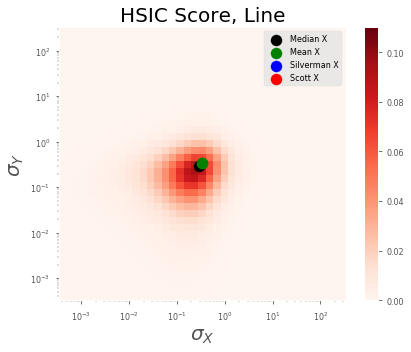

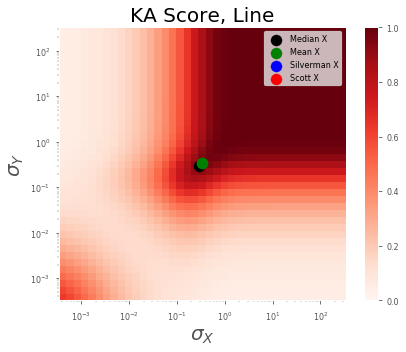

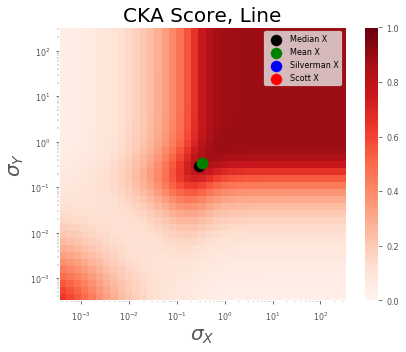

In [232]:
scorers = results_df['scorer'].unique().tolist()
idataset = 'line'

for iscorer in scorers:

    fig, ax = plot_all_params(results_df, results_est_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    plt.xscale('log', basex=10)
    plt.yscale('log', basey=10)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()



#### Sine Dataset

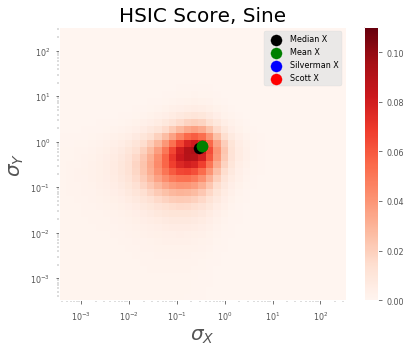

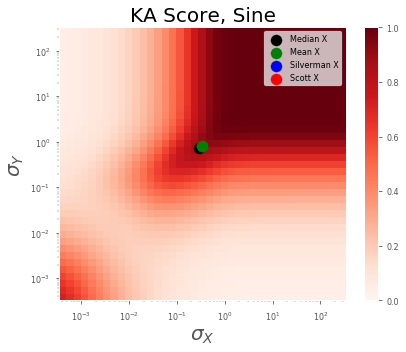

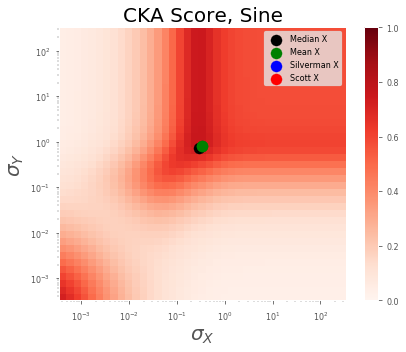

In [233]:
scorers = results_df['scorer'].unique().tolist()
idataset = 'sine'

for iscorer in scorers:

    fig, ax = plot_all_params(results_df, results_est_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    plt.xscale('log', basex=10)
    plt.yscale('log', basey=10)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

#### Circle Dataset

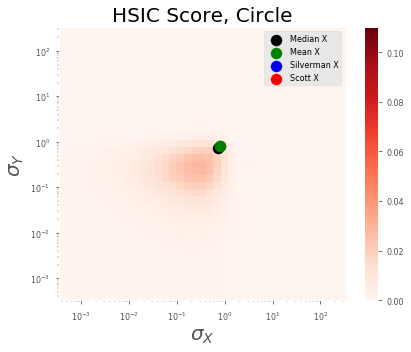

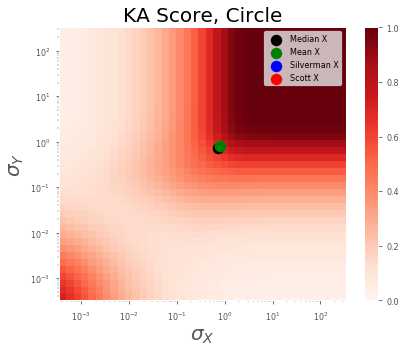

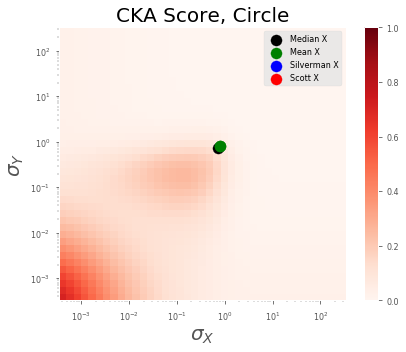

In [234]:
scorers = results_df['scorer'].unique().tolist()
idataset = 'circle'

for iscorer in scorers:

    fig, ax = plot_all_params(results_df, results_est_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    plt.xscale('log', basex=10)
    plt.yscale('log', basey=10)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()

#### Random Dataset

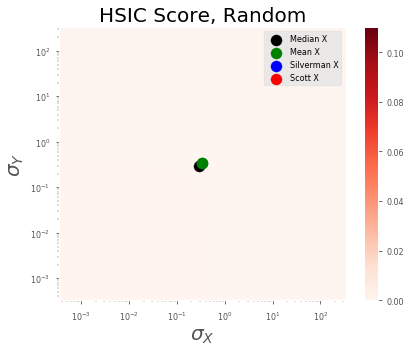

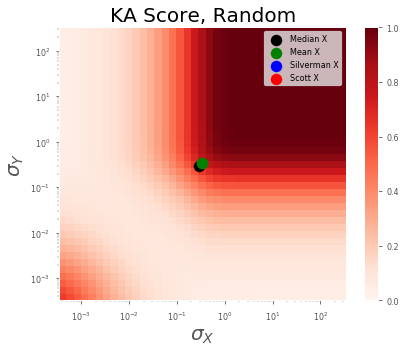

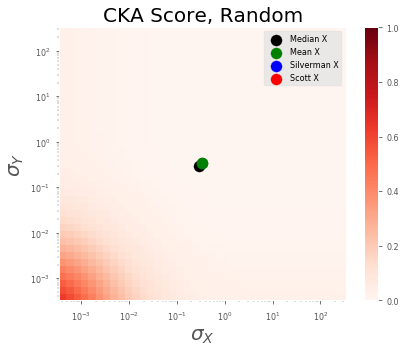

In [235]:
scorers = results_df['scorer'].unique().tolist()
idataset = 'random'

for iscorer in scorers:

    fig, ax = plot_all_params(results_df, results_est_df, scorer=iscorer, dataset=idataset)

    # ax.legend(ncol=1, fontsize=15)
    plt.xscale('log', basex=10)
    plt.yscale('log', basey=10)
    ax.set_xlabel(r'$\sigma_X$', fontsize=20)
    ax.set_ylabel(r'$\sigma_Y$', fontsize=20)
    ax.set_title(f'{iscorer.upper()} Score, {idataset.capitalize()}', fontsize=20)
    plt.tight_layout()
    plt.show()